In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install accelerate
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 6.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [54]:
from collections import Counter
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from huggingface_hub import HfFolder, Repository
from sklearn.metrics import cohen_kappa_score
from datasets import Dataset, get_dataset_config_names
import polars as pl
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np
from transformers import (AutoTokenizer,
                          TrainingArguments,
                          DataCollatorWithPadding,
                          Trainer,
                          AutoModelForSequenceClassification,
                           EarlyStoppingCallback
                          )
import regex as re
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from google.colab import userdata
import ctypes, torch, gc, yaml,  joblib, spacy, multiprocessing, os, random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [4]:
key_ = userdata.get('HF_TOKEN')
cuda_available = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
train_path = '/content/drive/MyDrive/essay/data/train.csv'
libc = ctypes.CDLL("libc.so.6")

cuda


In [5]:
args_no = 3
args = f'/content/drive/MyDrive/essay/args/args_{args_no}.yaml'

with open(args, 'r') as file:
  config = yaml.safe_load(file)


In [6]:

def clear_memory():
    libc.malloc_trim(0)
    torch.cuda.empty_cache()
    gc.collect()



In [7]:
lbl_mapping = { j: i for i, j in enumerate(config['lbl'])}


df_full = (pl.scan_csv(train_path)
        .with_columns(
            score = pl.col('score')
            .replace(lbl_mapping)
        )
      )


In [8]:
def initialize_seeds(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

initialize_seeds(config['seed'])

In [9]:


class text_prep():
  def __init__(self,
               df,
               tokenizer,
               max_length = config['max_length'],
               batch_size = config['batch_size'],
               stride = config['stride']
               ):

    self.set_df(df)
    self.tokenizer = tokenizer
    self.max_length = max_length
    self.batch_size  = batch_size
    self.stride = stride

  def tokenize_function(self, batch):
    try:
        input_ids = []
        essay_id = []
        attention_mask = []
        full_text = []
        score = []
        txts = [self.preprocess_text(i) for i in batch['full_text']]

        for count_id , txt in enumerate(txts):
          tokenized = self.tokenizer(txt,
                                    max_length=self.max_length,
                                    return_overflowing_tokens = True,
                                    stride = self.stride,
                                    truncation=True
                                    )


          for count, input in enumerate(tokenized['input_ids']):
            full_text.append(txt)
            score.append(batch['score'][count_id])
            essay_id.append(batch['essay_id'][count_id])
            input_ids.append(input)
            attention_mask.append(tokenized['attention_mask'][count])

        return {
            'essay_id': essay_id,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'full_text': full_text,
            'score': score
        }
    except Exception as e:
        print(f"Error tokenizing batch: {batch}")
        raise e

  def preprocess_text(self, text):
    text = text.replace('\xa0', ' ')
    text = re.sub(r"[^a-zA-Z0-9\s,.'!?;:-]", '', text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

  def set_df(self, val):
    if isinstance(val, Dataset):
      self.df = val
    elif isinstance(val, pl.DataFrame):
      arrow_table = val.to_arrow()
      self.df = Dataset(arrow_table)
    else:
      raise TypeError("Unsupported data")



  def fit_transform(self):
     return (self.df.map(self.tokenize_function,
                         num_proc=multiprocessing.cpu_count() -1,
                         batched = True
                         )
                    .rename_column('score', 'labels')
     )


In [10]:
tokenizer = AutoTokenizer.from_pretrained(config['best_model'])
def token_df(tokenizer, df_full):
  df_sample = df_full.collect()
  tp = text_prep(df_sample, tokenizer = tokenizer)
  return tp.fit_transform()


tokenizer_config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [11]:


def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    qwk = cohen_kappa_score(p.label_ids, preds, weights="quadratic")
    return {
        'qwk': float(qwk),
    }


In [12]:
df = token_df(tokenizer, df_full)



/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=7):   0%|          | 0/17307 [00:00<?, ? examples/s]

In [13]:

essay_id = list(set(df['essay_id']))

df_pd = (
        df_full
        .filter(pl.col('essay_id').is_in(essay_id))
        .collect()
        .to_pandas()
)


df_dic = {}
stratified_kfold = StratifiedKFold(n_splits=config['num_folds'], shuffle=True, random_state=config['seed'])
for fold, (train_index, test_index) in enumerate(stratified_kfold.split(df_pd, df_pd['score'])):

    if fold == config['best_batch']:
      print(f'fold number: {fold}')
      train_index, val_index = train_test_split(train_index, test_size=0.2, random_state=config['seed'])
      df_dic[fold] = {
        'train': df.filter(lambda f: f['essay_id'] in df_pd.iloc[train_index].loc[:, 'essay_id'].to_list()),
        'vali': df.filter(lambda f: f['essay_id'] in df_pd.iloc[val_index].loc[:, 'essay_id'].to_list()),
        'test':  df.filter(lambda f: f['essay_id'] in df_pd.iloc[test_index].loc[:, 'essay_id'].to_list())
      }
      break



fold number: 3


Filter:   0%|          | 0/22212 [00:00<?, ? examples/s]

Filter:   0%|          | 0/22212 [00:00<?, ? examples/s]

Filter:   0%|          | 0/22212 [00:00<?, ? examples/s]

In [14]:
test = df_dic[config['best_batch']]['test']


In [15]:
test


Dataset({
    features: ['essay_id', 'full_text', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 4446
})

In [16]:
model = AutoModelForSequenceClassification.from_pretrained(config['best_model'])
model.eval()
model.to(device)

data_collator = DataCollatorWithPadding(tokenizer,
                                        pad_to_multiple_of=config['pad_to_multiple_of']
                                        )


def predict(batch, device=device, model = model):
    collated_batch = data_collator({k: batch[k]
                                    for k in batch
                                    if k in ['input_ids', 'attention_mask']}
                                   )
    input_ids = collated_batch['input_ids'].to(device)
    attention_mask = collated_batch['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    probabilities = torch.nn.functional.softmax(logits, dim=-1).cpu().numpy()
    pred_labels = torch.argmax(logits, dim=-1).cpu().numpy()

    return {
        'pred_labels': pred_labels.tolist(),
        'probabilities': probabilities.tolist()
    }


pred = test.map(predict,
                batched = True,
                batch_size = config['batch_size'],
               ).remove_columns(['input_ids', 'attention_mask'])

clear_memory()

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Map:   0%|          | 0/4446 [00:00<?, ? examples/s]

In [80]:
def most_common(lst):
  counts = Counter(lst)
  max_frequency = max(counts.values())
  return [e for e, c in counts.items() if c == max_frequency]


def vote_pred(r):

  lbl_agg = r['lbl_agg']
  max_value_agg = r['max_value_agg']

  if len(lbl_agg) > 1:
    mc = most_common(lbl_agg)
    val_dic = {}
    data = list(zip(lbl_agg, max_value_agg))

    if len(mc) > 1:
      for i in mc:
        val_dic[i] = max(val for lbl, val in data if i == lbl)
    else:
      val_dic[mc[0]] = max(val for lbl, val in data if mc[0] == lbl)

    max_lbl = max(val_dic, key=val_dic.get)
    return {'new_lbl': max_lbl, 'val': val_dic[max_lbl]}
  else:
    return {'new_lbl': lbl_agg[0], 'val': max_value_agg[0]}


raw_pred = pred.to_polars()


pred_final = (
              (raw_pred
              .with_columns(
                      max_value = pl.col('probabilities').list.max(),
              )
              .group_by('essay_id')
                .agg(
                    lbl_agg = pl.col('pred_labels'),
                    max_value_agg = pl.col('max_value')
                )
                  .with_columns(
                      temp = pl.struct(['lbl_agg', 'max_value_agg'])
                               .map_elements(lambda g: vote_pred(g))
               )
                .unnest('temp')
                .drop(['max_value_agg', 'lbl_agg'])
             ).join(
                 (raw_pred
                 .select(['essay_id', 'labels', 'full_text'])
                 .unique()
                 )
                 , on = 'essay_id'
             )
)
pred_final


essay_id,new_lbl,val,labels,full_text
str,i64,f64,i64,str
"""0516f28""",1,0.945004,0,"""Limiting car u…"
"""05508b4""",1,0.963147,1,"""The author is …"
"""05e1eae""",1,0.855005,1,"""The Venus are …"
"""06041d8""",2,0.903808,2,"""In the article…"
"""07e4b76""",3,0.9226,2,"""Do you think t…"
"""08669b6""",2,0.954213,1,"""You have to pa…"
"""08d4d59""",3,0.784563,3,"""In The Challen…"
"""08dac82""",2,0.954953,2,"""Driverless car…"
"""0975e3f""",3,0.513935,3,"""Driverless car…"


In [70]:

kappa = cohen_kappa_score(pred_final["labels"], pred_final["new_lbl"], weights="quadratic")
kappa

0.7894520582936333

In [71]:
def confusion(scoring):
  labels = sorted(scoring[:, 'labels'].unique().to_list())


  cm = confusion_matrix(scoring[:, "labels"].to_list(),
                        scoring[:, "new_lbl"].to_list(),
                        labels=labels,
                        )
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap=plt.cm.Blues)
  ax = disp.ax_
  plt.xticks(range(len(labels)), labels, rotation=90, ha='right')
  plt.subplots_adjust(bottom=0.2)
  plt.show()


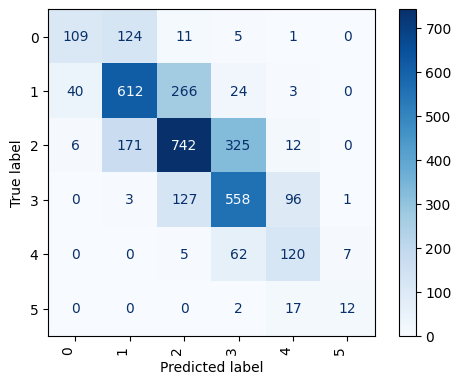

In [72]:
confusion(pred_final)

In [112]:
from sklearn.metrics import classification_report
(pd.DataFrame(classification_report(pred_final["labels"], pred_final["new_lbl"], output_dict = True))
.T
.iloc[0:6]

)

,precision,recall,f1-score,support
0,0.703226,0.436000,0.538272,250.0
1,0.672527,0.647619,0.659838,945.0
2,0.644657,0.590764,0.616535,1256.0
3,0.571721,0.710828,0.633731,785.0
4,0.481928,0.618557,0.541761,194.0
5,0.600000,0.387097,0.470588,31.0
